Model

$$u = \alpha(x) + \beta(x) t + u, u \sim N(0,1)$$
$$\alpha(x) = 0.2 x_1 -0.3 x_2 -0.5 x_3$$
$$\beta(x) = 2 - x_2 -0.25 x_1^3$$
$$P[y=1|X, T] = \frac{1}{1+e^{-u}}$$



Data

In [2]:
import torch as to
import numpy as np
import matplotlib.pyplot as plt
np.random.seed(123423)
to.manual_seed(123423)
n = 100000
d_x = 3
d_param = 2
d_z = 1
device = ("cuda" if to.cuda.is_available() else "cpu")
print(f"Using {device} device")
x = to.randn((n, d_x)).to(device)
b = 1 + (- x[:, 1] - 0.25 * x[:, 0] ** 3).to(device)
a = -1 + (0.2 * x[:, 0] - 0.3 * x[:, 1] - 0.5 * x[:, 2]).to(device)
z = (0+1*to.randn(n, ) > 0).type(to.float32).to(device)
u = (to.randn((n,))).to(device)
y_star = (a + b * z + 0.5*u).to(device)
y = (to.sigmoid(y_star)>0.5).type(to.float32).to(device)
#y = (to.bernoulli(to.sigmoid(y_star))).type(to.float32).to(device)
print(y.shape, x.shape, z.shape, a.shape, b.shape)
print(to.mean(y))

Using cpu device
torch.Size([100000]) torch.Size([100000, 3]) torch.Size([100000]) torch.Size([100000]) torch.Size([100000])
tensor(0.3004)


Deep Net

In [4]:
from torch import nn

class NeuralNetwork(nn.Module):
    def __init__(self, d_x, arch, d_param):
        super().__init__()
        layers = [nn.Flatten()]
        prev_dim = d_x
        for dim in arch:
            layers.append(nn.Linear(prev_dim, dim))
            layers.append(nn.ReLU())
            prev_dim = dim
        layers.append(nn.Linear(prev_dim, d_param)) # Final layer
        self.layers = nn.Sequential(*layers)

    def forward(self, x):
        return self.layers(x)

# Example usage
arch = [20,20]
model = NeuralNetwork(d_x, arch, d_param).to(device)
print(model)
print(model(x))

NeuralNetwork(
  (layers): Sequential(
    (0): Flatten(start_dim=1, end_dim=-1)
    (1): Linear(in_features=3, out_features=20, bias=True)
    (2): ReLU()
    (3): Linear(in_features=20, out_features=20, bias=True)
    (4): ReLU()
    (5): Linear(in_features=20, out_features=2, bias=True)
  )
)
tensor([[-0.1769, -0.0322],
        [-0.2940, -0.1464],
        [-0.2303, -0.3285],
        ...,
        [-0.0676, -0.2286],
        [-0.2866, -0.0766],
        [-0.1811, -0.0592]], grad_fn=<AddmmBackward0>)


Train

In [ ]:
from sklearn.model_selection import train_test_split
from sklearn.metrics import f1_score
import numpy as np
import torch
from torch import nn
from torch.nn.functional import binary_cross_entropy_with_logits
x_train, x_test, y_train, y_test, z_train, z_test = train_test_split(x, y, z, test_size=0.3, random_state=42)
optimizer = torch.optim.Adam(model.parameters(), lr=0.001, weight_decay=0.0001)
loss_fn = nn.BCELoss(reduction='mean')
m = 10000
n_train = x_train.shape[0]

# Training Loop
for t in range(m):
    params = model(x_train)
    alpha = params[:, 0].reshape(n_train,)
    beta = params[:, 1].reshape(n_train,)
    y_star_hat = alpha + beta * z_train
    y_hat = torch.sigmoid(y_star_hat)
    y_pred_train = (y_hat > 0.5).float()
    loss = loss_fn(y_hat, y_train)
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
    with torch.no_grad():
        params_test = model(x_test)
        alpha_test = params_test[:, 0].reshape(x_test.shape[0],)
        beta_test = params_test[:, 1].reshape(x_test.shape[0],)
        y_star_hat_test = alpha_test + beta_test * z_test
        y_hat_test = torch.sigmoid(y_star_hat_test)
        y_pred_test = (y_hat_test > 0.5).float()
        accuracy_test = (y_pred_test == y_test).float().sum() / y_test.shape[0]
        f1_test = f1_score(y_test.cpu().numpy(), y_pred_test.cpu().numpy(), average='binary')
        if t % (m/10) == 0:
            print(f"Iteration {t}, Train Loss: {loss.item()}, Test Accuracy: {accuracy_test.item()}, Test F1 Score: {f1_test}")


Iteration 0, Train Loss: 0.6589245796203613, Test Accuracy: 0.7006666660308838, Test F1 Score: 0.004875886524822695
Iteration 1000, Train Loss: 0.21936646103858948, Test Accuracy: 0.9063000082969666, Test F1 Score: 0.8377301853027767
Iteration 2000, Train Loss: 0.2171507179737091, Test Accuracy: 0.9072333574295044, Test F1 Score: 0.8392351683900411
Iteration 3000, Train Loss: 0.21684227883815765, Test Accuracy: 0.9072666764259338, Test F1 Score: 0.8394135303625028


KeyboardInterrupt: 

Alternative Models

In [ ]:
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from xgboost import XGBClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.metrics import accuracy_score, f1_score
import torch

# Assuming x and t are your feature tensors in PyTorch and y is the label tensor
X = x.cpu().numpy()
T = z.cpu().numpy()  # Replace 't' with your actual tensor name
Y = y.cpu().numpy()

# Reshape T if it is 1D
if T.ndim == 1:
    T = T.reshape(-1, 1)

# Concatenate X and T along the feature dimension
XT = np.concatenate((X, T), axis=1)

# Split the dataset
XT_train, XT_test, Y_train, Y_test = train_test_split(XT, Y, test_size=0.3, random_state=42)

# Logistic Regression
model_logistic = LogisticRegression()
model_logistic.fit(XT_train, Y_train)
y_pred_logistic = model_logistic.predict(XT_test)
print(f"Logistic Regression Accuracy: {accuracy_score(Y_test, y_pred_logistic)}")
print(f"Logistic Regression F1 Score: {f1_score(Y_test, y_pred_logistic, average='binary')}")

# XGBoost Classifier
model_xgb = XGBClassifier(max_depth=6, use_label_encoder=False, eval_metric='logloss')
model_xgb.fit(XT_train, Y_train)
y_pred_xgb = model_xgb.predict(XT_test)
print(f"XGBoost Classifier Accuracy: {accuracy_score(Y_test, y_pred_xgb)}")
print(f"XGBoost Classifier F1 Score: {f1_score(Y_test, y_pred_xgb, average='binary')}")

# MLP Classifier
model_mlp = MLPClassifier(hidden_layer_sizes=(50,50), max_iter=1000, activation='relu', solver='adam', random_state=42)
model_mlp.fit(XT_train, Y_train)
y_pred_mlp = model_mlp.predict(XT_test)
print(f"MLP Classifier Accuracy: {accuracy_score(Y_test, y_pred_mlp)}")
print(f"MLP Classifier F1 Score: {f1_score(Y_test, y_pred_mlp, average='binary')}")

Logistic Regression Accuracy: 0.8787333333333334
Logistic Regression F1 Score: 0.7904136421246687
XGBoost Classifier Accuracy: 0.9039333333333334
XGBoost Classifier F1 Score: 0.8339287772271523
MLP Classifier Accuracy: 0.9067666666666667
MLP Classifier F1 Score: 0.8437168240487232


Estimated Params

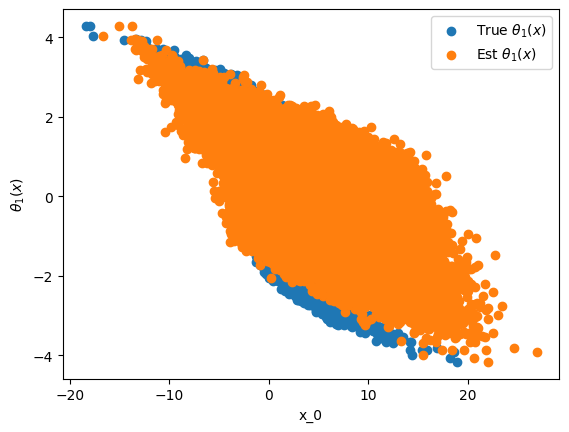

In [ ]:
params = model(x)
alpha = params[:, 0]
beta = params[:, 1]

import matplotlib.pyplot as plt
plt.scatter(b.cpu().detach().numpy(), x[:,0].cpu().detach().numpy(), label = f'True $\\theta_1(x)$')
plt.scatter(beta.cpu().detach().numpy(), x[:,0].cpu().detach().numpy(), label = f'Est $\\theta_1(x)$')
plt.xlabel('x_0')
plt.ylabel(f'$\\theta_1(x)$')

plt.legend()
plt.show()

In [ ]:
print(np.mean(b.cpu().detach().numpy()))
print(np.mean(beta.cpu().detach().numpy()))
print(np.mean(a.cpu().detach().numpy()))
print(np.mean(alpha.cpu().detach().numpy()))

0.9967366
4.2012076
-0.99965787
-4.087461


In [ ]:
from scipy.stats import spearmanr
print(spearmanr(b.cpu().detach().numpy(), beta.cpu().detach().numpy()))
print(spearmanr(a.cpu().detach().numpy(), alpha.cpu().detach().numpy()))

SignificanceResult(statistic=0.978547538991023, pvalue=0.0)
SignificanceResult(statistic=0.9950752688205663, pvalue=0.0)


<Axes: ylabel='Density'>

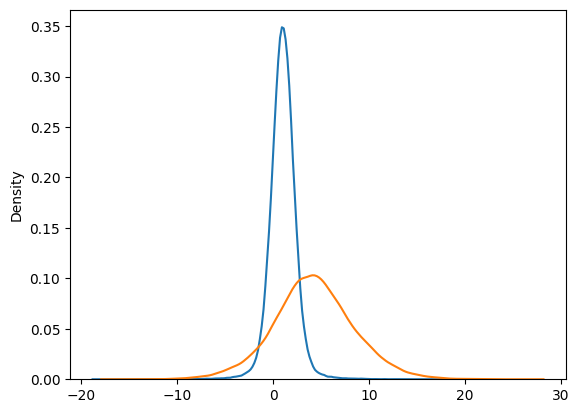

In [ ]:
import seaborn as sns
sns.kdeplot(b.cpu().detach().numpy())
sns.kdeplot(beta.cpu().detach().numpy())

<Axes: ylabel='Density'>

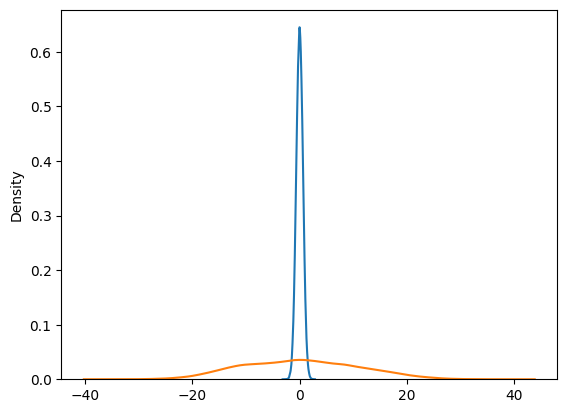

In [ ]:
import seaborn as sns
sns.kdeplot(a.cpu().detach().numpy())
sns.kdeplot(alpha.cpu().detach().numpy())

APPLICATION

In [ ]:
from sklearn.preprocessing import OneHotEncoder
import pandas as pd
from torch import nn
import numpy as np
import torch

# load
data_df = pd.read_csv('/content/marketing_AB 3.csv')
data_df.drop(columns=['Unnamed: 0', 'user id'], inplace=True)
data_df['test group'] = (data_df['test group'] == 'ad').astype(int)
data_df['converted'] = data_df['converted'].astype(int)

# oversampling
minority_class = data_df[data_df['converted'] == 1]
oversampled_minority_class = pd.concat([minority_class] * 3, ignore_index=True)
oversampled_data = pd.concat([data_df, oversampled_minority_class], ignore_index=True)
oversampled_data = oversampled_data.sample(frac=1, random_state=42).reset_index(drop=True)
data_df = oversampled_data.copy()

# encoding
encoder = OneHotEncoder(sparse=False)
encoded_days = encoder.fit_transform(data_df[['most ads day']])
day_columns = encoder.get_feature_names_out(['most ads day'])
encoded_data = np.concatenate((data_df[['total ads', 'most ads hour']].values, encoded_days), axis=1)
device = "cuda" if torch.cuda.is_available() else "cpu"

# tensors
x = torch.tensor(encoded_data, dtype=torch.float32).to(device)
z = torch.tensor(data_df['test group'].values, dtype=torch.float32).to(device)
y = torch.tensor(data_df['converted'].values, dtype=torch.float32).to(device)
d_x = x.shape[1]
d_param = 2
d_z = z.shape[0]

class NeuralNetwork(nn.Module):
    def __init__(self, d_x, arch, d_param):
        super().__init__()
        layers = [nn.Flatten()]

        # Creating the layers dynamically
        prev_dim = d_x
        for dim in arch:
            layers.append(nn.Linear(prev_dim, dim))
            layers.append(nn.ReLU())
            prev_dim = dim

        layers.append(nn.Linear(prev_dim, d_param)) # Final layer

        self.layers = nn.Sequential(*layers)

    def forward(self, x):
        return self.layers(x)

# Example usage
arch = [20,20]
model = NeuralNetwork(d_x, arch, d_param).to(device)
print(model)
print(model(x))

from sklearn.model_selection import train_test_split
from sklearn.metrics import f1_score
import numpy as np
import torch
from torch import nn
from torch.nn.functional import binary_cross_entropy_with_logits
x_train, x_test, y_train, y_test, z_train, z_test = train_test_split(x, y, z, test_size=0.3, random_state=42)
optimizer = torch.optim.Adam(model.parameters(), lr=0.001, weight_decay=0.0001)
loss_fn = nn.BCELoss(reduction='mean')
m = 10000
n_train = x_train.shape[0]

# Training Loop
for t in range(m):
    params = model(x_train)
    alpha = params[:, 0].reshape(n_train,)
    beta = params[:, 1].reshape(n_train,)
    y_star_hat = alpha + beta * z_train
    y_hat = torch.sigmoid(y_star_hat)
    y_pred_train = (y_hat > 0.5).float()
    loss = loss_fn(y_hat, y_train)
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
    with torch.no_grad():  # No need to track gradients
        params_test = model(x_test)
        alpha_test = params_test[:, 0].reshape(x_test.shape[0],)
        beta_test = params_test[:, 1].reshape(x_test.shape[0],)
        y_star_hat_test = alpha_test + beta_test * z_test
        y_hat_test = torch.sigmoid(y_star_hat_test)
        y_pred_test = (y_hat_test > 0.5).float()
        accuracy_test = (y_pred_test == y_test).float().sum() / y_test.shape[0]
        f1_test = f1_score(y_test.cpu().numpy(), y_pred_test.cpu().numpy(), average='binary')
        if t % (m/10) == 0:
            print(f"Iteration {t}, Train Loss: {loss.item()}, Test Accuracy: {accuracy_test.item()}, Test F1 Score: {f1_test}")


/usr/local/lib/python3.10/dist-packages/sklearn/preprocessing/_encoders.py:868: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(


NeuralNetwork(
  (layers): Sequential(
    (0): Flatten(start_dim=1, end_dim=-1)
    (1): Linear(in_features=9, out_features=20, bias=True)
    (2): ReLU()
    (3): Linear(in_features=20, out_features=20, bias=True)
    (4): ReLU()
    (5): Linear(in_features=20, out_features=2, bias=True)
  )
)
tensor([[0.4072, 0.1192],
        [0.5544, 0.2927],
        [0.4430, 0.1281],
        ...,
        [0.9929, 0.8256],
        [1.2236, 0.9142],
        [0.6525, 0.4517]], device='cuda:0', grad_fn=<AddmmBackward0>)
Iteration 0, Train Loss: 1.5519459247589111, Test Accuracy: 0.09347749501466751, Test F1 Score: 0.1709728713920879
Iteration 1000, Train Loss: 0.22913658618927002, Test Accuracy: 0.9069440364837646, Test F1 Score: 0.15030069761847487


KeyboardInterrupt: 

<Axes: ylabel='Density'>

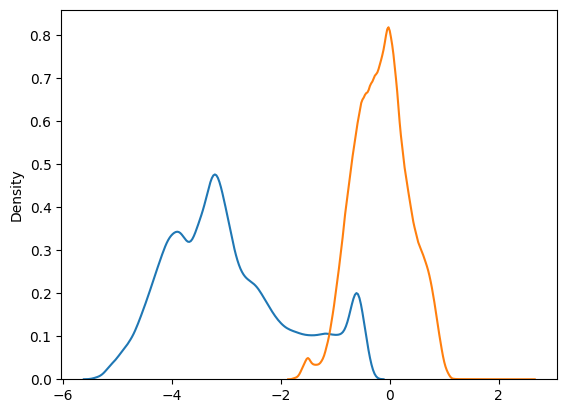

In [ ]:
import seaborn as sns
sns.kdeplot(alpha.cpu().detach().numpy())
sns.kdeplot(beta.cpu().detach().numpy())

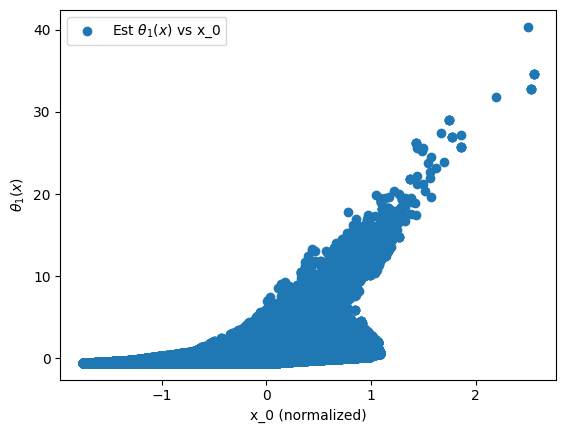

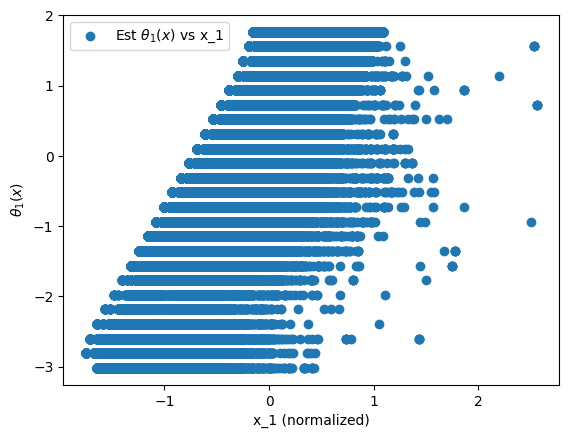

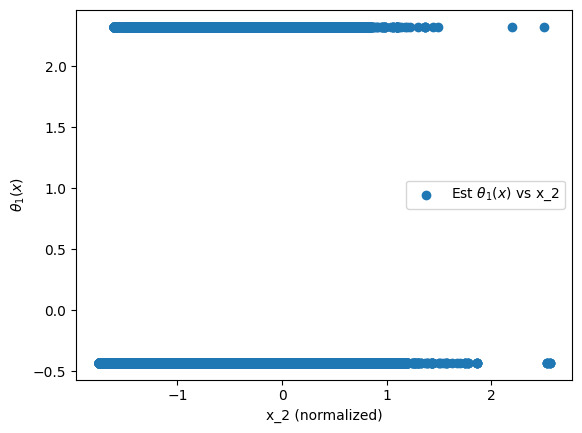

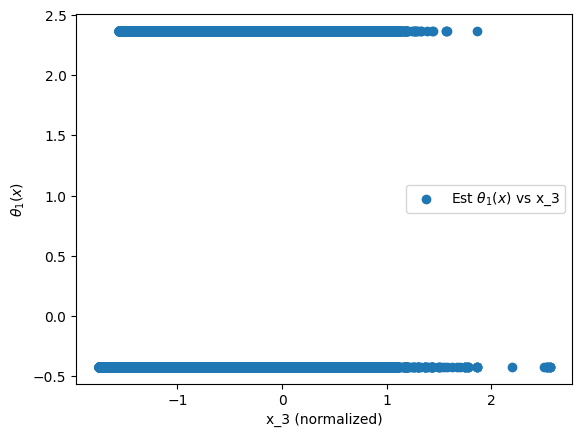

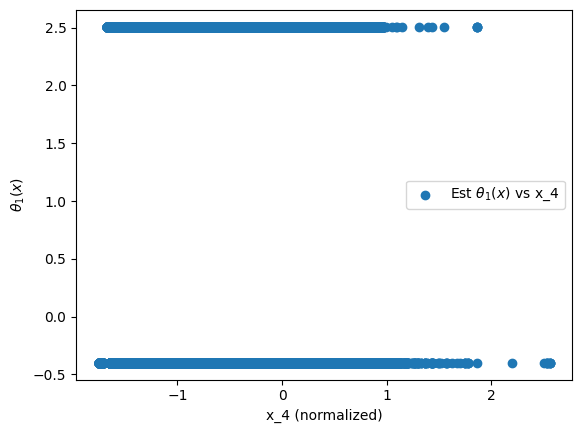

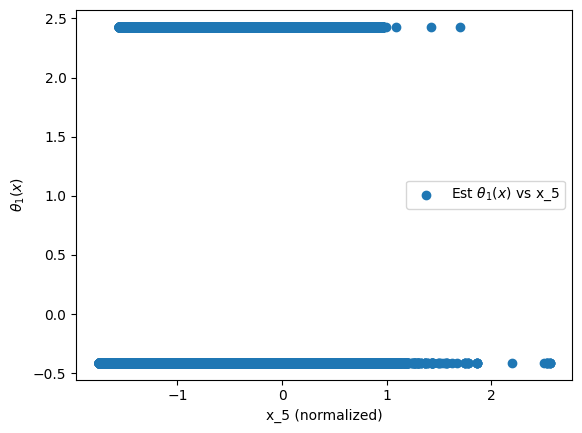

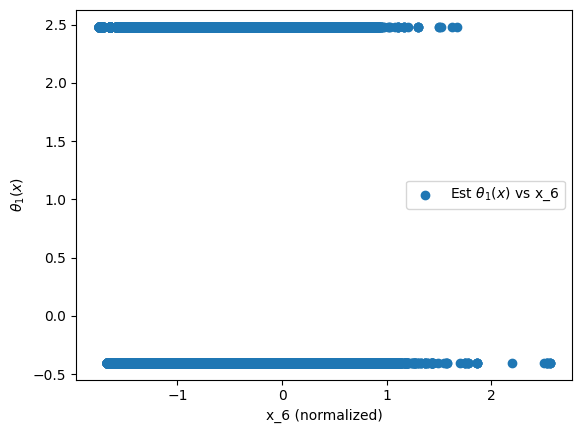

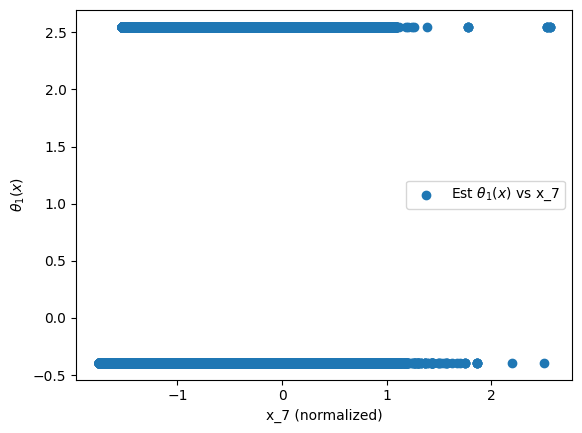

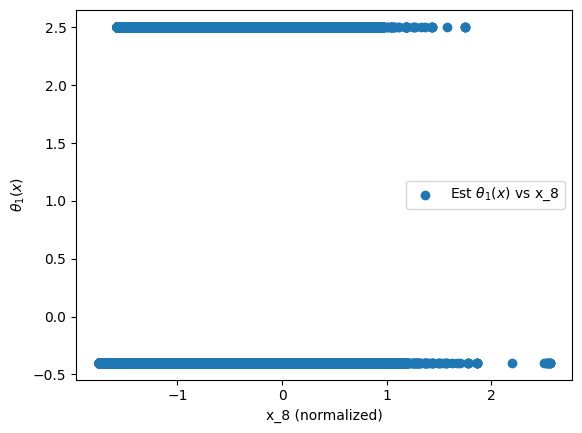

In [ ]:
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt

# Assuming x is a tensor of your features and beta is obtained from your model
x_np = x.cpu().detach().numpy()  # Convert to numpy array if it's a tensor
beta_np = beta.cpu().detach().numpy()

# Normalize the features
scaler = StandardScaler()
x_normalized = scaler.fit_transform(x_np)

# Plotting
for i in range(x_normalized.shape[1]):
    plt.scatter(beta_np, x_normalized[:, i], label=f'Est $\\theta_1(x)$ vs x_{i}')
    plt.xlabel(f'x_{i} (normalized)')
    plt.ylabel(f'$\\theta_1(x)$')
    plt.legend()
    plt.show()

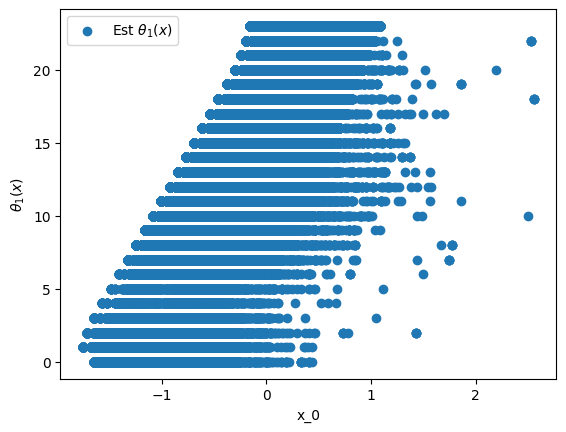

In [ ]:
import matplotlib.pyplot as plt
#plt.scatter(b.cpu().detach().numpy(), x[:,0].cpu().detach().numpy(), label = f'True $\\theta_1(x)$')
plt.scatter(beta.cpu().detach().numpy(), x[:,1].cpu().detach().numpy(), label = f'Est $\\theta_1(x)$')
plt.xlabel('x_0')
plt.ylabel(f'$\\theta_1(x)$')
plt.legend()
plt.show()